# This notebook derives the noise model for the umux readout


In [40]:
# setup the python
%matplotlib inline
import numpy as np
import argparse
import matplotlib.pyplot as plt
import pandas as pd

# Start with the chip design parameters

The input coupling is 9.039 pA/uphi_0
The TES current to RF freq shift is 0.055 Hz/pA


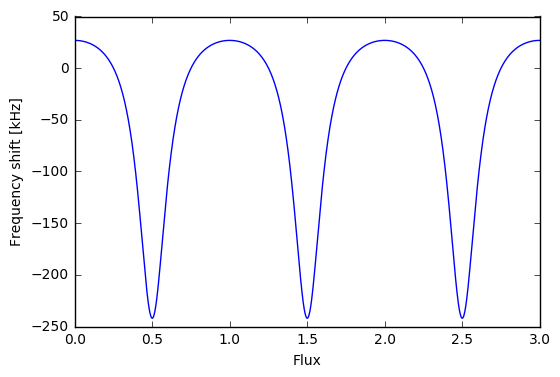

In [24]:
f_res = 5e9 # resonance frequency = 5GHz
res_bw = 100e3 # current gen bandwidth = 100kHz, need >75kHz
M_input = 229e-12 # input mutual inductance to squid= 229 pH
M_flxramp = 26.9e-12 # flux ramp to squid
M_sqres = 1.65e-12/2 # squid to resonator
L_sq = 22.5e-12 # squid self inductance
Q_c = f_res/res_bw # coupled Q
Q_i = 100e3 # internal Q
lmbda = 0.8 # lambda = L_sq/L_J designed for 0.3, but measured at 0.8
# define the degradetion factor
if lmbda == 0.8:
    alpha = 1.64
else:
    alpha = 0.8
flux_quantum = 2.07e-15 # in Wb
Z_1 = 50 # impedence of the microstrip

# now define some of the necessary conversion 
didphi = flux_quantum/M_input*1e6 # pA/uphi_0 the 1e6 is to convert from A/phi_0
dfdi = 1e-12*4*f_res**2*M_sqres**2*lmbda*alpha*2*np.pi*M_input/(Z_1*L_sq*flux_quantum)

print('The input coupling is ' + str.format('{0:.3f}',didphi)+ ' pA/uphi_0')
print('The TES current to RF freq shift is '+str.format('{0:.3f}',dfdi) + ' Hz/pA')

# now lets also plot the resulting flux sweep
flux = np.linspace(0,3,1000)
df = 4*f_res**2*M_sqres**2*lmbda*np.cos(flux*2*np.pi)/(Z_1*L_sq*(1+lmbda*np.cos(flux*2*np.pi)))
plt.plot(flux,df*1e-3)
plt.xlabel('Flux')
plt.ylabel('Frequency shift [kHz]')

# Start modeling the noise of the electronics
## Begin with the RF noise
### Phase noise
The phase noise is dependent on the local oscillator and the clock.  

In [39]:
S_phi = -90 # noise from the LO in dBc/Hz
N_phi = 10**(S_phi/20)*res_bw/2/dfdi
print('The phase noise referred to input is '+
      str.format('{0:.3f}',N_phi)+' pA/rt(Hz)')

NameError: name 'noise' is not defined

# DC Noise
Flux ramp and TES bias

In [37]:
# define the TES parameters
R_sh = 0.003 # 3 mOhms
R_tes = 0.06 # 60 mOhms

# Set the TES bias line current noise at 50 pA/rt(Hz)
I_tes_bias = 50 # pA/rt(Hz)
I_b = R_sh/(R_sh+R_tes)*I_tes_bias
print('The TES bias line noise referred to input is '+
     str.format('{0:.3f}',I_b) +' pA/rt(Hz)') 

# Set the flux ramp line current noise to 50 pA/rt(Hz)
I_flux_ramp = 50 #pA/rt(Hz)
I_f = M_flxramp/M_input*I_flux_ramp
print('The flux ramp bias line noise referred to input is '+
     str.format('{0:.3f}',I_f) +' pA/rt(Hz)') 

The TES bias line noise referred to input is 2.381 pA/rt(Hz)
The flux ramp bias line noise referred to input is 5.873 pA/rt(Hz)


## Total noise budget

In [66]:
noise = {'source': ['Phase noise','TES bias','flux ramp'],
         'intrinsic value':[S_phi,I_tes_bias,I_flux_ramp],
         'refered to input':[N_phi,I_b,I_f]}
noise_frame = pd.DataFrame(noise,columns=['source','intrinsic value','refered to input'] )
rti=noise_frame['refered to input']**2
t = pd.Series({'source':'total noise',
     'refered to input':np.sqrt(rti.sum())})
noise_frame.append(t,ignore_index=True)

,source,intrinsic value,refered to input
0,Phase noise,-90.0,28.657334
1,TES bias,50.0,2.380952
2,flux ramp,50.0,5.873362
3,total noise,NaN,29.349755
